# 1. Let's build the transformer's encoder


## 1.0. Init

* Initialize the notebook environment.
* Hyperparameters definition


In [1]:
import torch
from torch import nn
import torch.nn.functional as F

from datasets import Dataset, DatasetDict, load_dataset
from transformers import AutoTokenizer

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import unittest

import os

In [2]:
# Hyperparameters Here
BATCH_SIZE = 128
T = 80  # sentence length
D_K = 16
D_V = 16
D_MODEL = 128
H = 8
VOCAB_SIZE = 10
N_TRANSFORMERS_BLOCKS_ENCODER = 6
N_CLASSES = 2  # classes of classifier

USE_CAUSAL_MASK = True

LOG_INTERVAL_IN_BATCHES = 10
EPOCHS = 12

ALLOW_GPU = True

RUN_UNIT_TESTS = True
TRAIN_MODEL = True

SEED = 42

In [3]:
# Set device
device = "cuda" if torch.cuda.is_available() and ALLOW_GPU else "cpu"
print("Using {} device".format(device))


# Set seeds to reprodutivity
torch.manual_seed(SEED)
np.random.seed(SEED)
print(f"Using manual seed: {SEED}")

Using cuda device
Using manual seed: 42


## 1.1. Attention


In [4]:
# Test softmax x axis:
matrix = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])

softmaxed_matrix = F.softmax(matrix, dim=1)

print(softmaxed_matrix)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])


In [5]:
def repeat(x: torch.Tensor, n: int):
    # make shape (n, 1, 1, ...) --> quantity of 1's must be len(x.shape)
    # for example, if shape of x is (3, 4, 8), shapee must be (n, 1, 1, 1)
    tuple_ones = tuple(
        (torch.tensor(x.shape) / torch.tensor(x.shape)).numpy().astype(int)
    )
    return x.unsqueeze(0).repeat((n, *tuple_ones))


def batched_matmul(tensor_3d, tensor_2d):
    W_repeated = repeat(tensor_2d, n=tensor_3d.shape[0])

    return torch.bmm(tensor_3d, W_repeated)

In [6]:
class Attention(nn.Module):
    """Convention from: https://www.udemy.com/course/data-science-transformers-nlp/learn/lecture/32255056#overview
    In our convention, K, Q and V are learneable, different from the "Attention is all you need" paper.
    """

    def __init__(self, d_K, d_V, d_model: int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        # Define trainable parameters with requires_grad=True
        # torch 2d tensor initialized normally
        self.W_K = nn.Parameter(torch.normal(mean=0, std=0.01, size=(d_model, d_K)))
        self.W_Q = nn.Parameter(torch.normal(mean=0, std=0.01, size=(d_model, d_K)))
        self.W_V = nn.Parameter(torch.normal(mean=0, std=0.01, size=(d_model, d_V)))

        self.register_buffer(
            "causal_mask", torch.tril(torch.ones((1, T, T))), persistent=False
        )

    def forward(self, x: torch.Tensor, pad_mask=None) -> torch.Tensor:
        """Forward pass of the Attention layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch, T, d_model)

        Returns:
            torch.Tensor: Output tensor of shape (batch, T, d_V)
            torch.Tensor: Attention weights of shape (batch, T, T)
        """
        # Shapes:
        # x is a 3d tensor (batch, T, d_model)
        # W_K (d_model, d_K)

        # (batch, T, d_model) x (d_model, d_K) -> (batch, T, d_K)
        K = batched_matmul(x, self.W_K)
        Q = batched_matmul(x, self.W_Q)
        V = batched_matmul(x, self.W_V)

        # (batch, T, d_K) x (batch, d_k, T) -> (batch, T, T)
        attention_scores = torch.bmm(Q, K.transpose(1, 2)) / (K.shape[-1] ** 0.5)

        if pad_mask is not None:
            # (batch, T, T) x (batch, T, 1) -> (batch, T, 1)
            attention_scores = attention_scores.masked_fill(pad_mask == 0, 0)

        if USE_CAUSAL_MASK:
            # Causal mask
            # (batch, T, T)
            attention_scores = attention_scores.masked_fill(self.causal_mask == 0, -np.inf)

        attention_weights = F.softmax(attention_scores, dim=-1)
        
        # (batch, T, T) x (batch, T, d_V) -> (batch, T, d_V)
        attention_scores = torch.bmm(attention_weights, V)

        return attention_scores, attention_weights

In [7]:
att = Attention(d_K=D_K, d_V=D_V, d_model=D_MODEL)
x = torch.normal(mean=0, std=0.01, size=(BATCH_SIZE, T, D_MODEL))

att_result, att_weights = att.forward(x)
assert att_result.shape == (BATCH_SIZE, T, D_V)
print(att.W_K.shape)
print(att.W_Q.shape)
print(att.W_V.shape)
print(att_result.shape)

torch.Size([128, 16])
torch.Size([128, 16])
torch.Size([128, 16])
torch.Size([128, 80, 16])


## 1.2. Multi-Head Attention


In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, d_K, d_V):
        super().__init__()
        self.h = h
        self.attentions = nn.ModuleList(
            [Attention(d_K=d_K, d_V=d_V, d_model=d_model) for _ in range(h)]
        )
        self.W_O = nn.Parameter(torch.normal(mean=0, std=0.01, size=(h * d_V, d_model)))

    def forward(self, x: torch.Tensor, pad_mask=None):
        """Forward pass of the MultiHeadAttention layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch, T, d_model)

        Returns:
            torch.Tensor: Output tensor of shape (batch, T, d_model)
            torch.Tensor: Attention weights of shape (batch, h, T, T)
        """
        attention_results = [attention(x, pad_mask)[0] for attention in self.attentions]
        attention_weights = torch.stack(
            [attention(x, pad_mask)[1] for attention in self.attentions]
        )
        concatenated = torch.cat(attention_results, dim=-1)
        return batched_matmul(concatenated, self.W_O), attention_weights

In [9]:
mha = MultiHeadAttention(h=H, d_K=D_K, d_V=D_V, d_model=D_MODEL)
out, att_weights = mha(x)
assert out.shape == (BATCH_SIZE, T, D_MODEL)

## 1.3. The transformer block


In [10]:
class TransformerBlock(nn.Module):
    def __init__(
        self, d_K=D_K, d_V=D_V, d_model=D_MODEL, h=H, dropout=0.1, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.mha = MultiHeadAttention(h, d_K=d_K, d_V=d_V, d_model=d_model)
        self.layer_norm = nn.LayerNorm(d_model)

        self.ann = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(d_model, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor, pad_mask=None):
        x = self.layer_norm(x + self.mha(x, pad_mask)[0])
        x = self.layer_norm(x + self.ann(x)[0])
        return x


transformerBlock = TransformerBlock()
transformerBlock(x).shape
transformerBlock.ann

Sequential(
  (0): Linear(in_features=128, out_features=128, bias=True)
  (1): Dropout(p=0.1, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): Dropout(p=0.1, inplace=False)
)

## 1.4. The positional encoding


In [11]:
def PositionalEncoding(t: int, d_model) -> torch.Tensor:
    encodings = torch.zeros(size=(t, d_model), requires_grad=False)
    counter = 0
    for pos in range(t):
        for i in range((d_model // 2) + 1):
            if 2 * i < d_model:
                counter += 1
                encodings[pos, 2 * i] = torch.sin(
                    pos / torch.tensor(10000).pow(2 * i / d_model)
                )
            if 2 * i + 1 < d_model:
                counter += 1
                encodings[pos, 2 * i + 1] = torch.cos(
                    pos / torch.tensor(10000).pow(2 * i / d_model)
                )
    assert counter == t * d_model
    return encodings


PositionalEncoding(T, D_MODEL).shape

torch.Size([80, 128])

In [12]:
torch.range(0, 10).reshape(-1, 1)

/tmp/ipykernel_61725/2721896283.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  torch.range(0, 10).reshape(-1, 1)


tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.]])

## 1.5. The embedding layer


In [13]:
# TODO: make this work in batches
class Embedding(nn.Module):
    def __init__(self, vocab_size, d_model, padding_idx=0):
        super(Embedding, self).__init__()
        self.embedding = nn.Parameter(
            torch.normal(
                mean=0.0, std=0.1, size=(vocab_size, d_model), requires_grad=True
            )
        )

    def forward(self, x):
        """forward pass Embedding layer

        Args:
            x (torch.Tensor): input Tensor of shape (batch_size, T)

        Returns:
            torch.Tensor: output Tensor of shape (batch_size, T, d_model)
        """
        return self.embedding[x.long()]


emb = Embedding(vocab_size=3, d_model=2)
# emb = nn.Embedding(num_embeddings=3, embedding_dim=2)
for name, param in emb.named_parameters():
    print(name, param.data)

input_emb = torch.FloatTensor([[2, 1], [1, 0], [0, 2]])

print(input_emb.shape)

out_emb = emb(input_emb.long())
print(out_emb.shape)
print(out_emb)

embedding tensor([[ 0.0699, -0.0838],
        [ 0.1141, -0.0243],
        [-0.0473,  0.1783]])
torch.Size([3, 2])
torch.Size([3, 2, 2])
tensor([[[-0.0473,  0.1783],
         [ 0.1141, -0.0243]],

        [[ 0.1141, -0.0243],
         [ 0.0699, -0.0838]],

        [[ 0.0699, -0.0838],
         [-0.0473,  0.1783]]], grad_fn=<IndexBackward0>)


In [14]:
class Encoder(nn.Module):
    def __init__(
        self,
        t=T,
        d_K=D_K,
        d_V=D_V,
        d_model=D_MODEL,
        h=H,
        vocab_size=VOCAB_SIZE,
        n_transformers=N_TRANSFORMERS_BLOCKS_ENCODER,
        dropout=0.1,
        *args,
        **kwargs
    ):
        super(Encoder, self).__init__()
        self.d_K = d_K
        self.d_V = d_V
        self.d_model = d_model
        self.h = h

        self.embedding = Embedding(vocab_size, d_model)
        self.position_encoding: torch.Tensor = PositionalEncoding(t, d_model)

        self.transformer_blocks = nn.ModuleList()
        for _ in range(n_transformers):
            self.transformer_blocks.append(
                TransformerBlock(d_K=d_K, d_V=d_V, d_model=d_model, h=h)
            )

    def forward(self, x: torch.Tensor, pad_mask=None):
        # if pad_mask is not None:
        #     assert pad_mask.shape == x.shape
        #     x = x.masked_fill(pad_mask == 0, 0)
        batchedPositionalEncoding = self.position_encoding.repeat(x.shape[0], 1, 1)
        x = self.embedding(x.int()).float()
        x = x + batchedPositionalEncoding

        for block in self.transformer_blocks:
            x = block(x)

        return x

    def to(self, *args, **kwargs):
        self.position_encoding = self.position_encoding.to(*args, **kwargs)
        return super().to(*args, **kwargs)

## 1.6. The Classification Encoder


In [15]:
class ClassifierEncoder(Encoder):
    def __init__(
        self,
        n_classes,
        t=T,
        d_K=D_K,
        d_V=D_V,
        d_model=D_MODEL,
        h=H,
        vocab_size=VOCAB_SIZE,
        n_transformers=N_TRANSFORMERS_BLOCKS_ENCODER,
        dropout=0.1,
        *args,
        **kwargs
    ):
        super(ClassifierEncoder, self).__init__()
        self.d_K = d_K
        self.d_V = d_V
        self.d_model = d_model
        self.h = h
        self.n_classes = n_classes

        self.embedding = Embedding(vocab_size, d_model)
        self.position_encoding: torch.Tensor = PositionalEncoding(t, d_model)

        self.transformer_blocks = nn.ModuleList()
        for _ in range(n_transformers):
            self.transformer_blocks.append(
                TransformerBlock(d_K=d_K, d_V=d_V, d_model=d_model, h=h)
            )

        self.prediction_head = nn.Linear(self.d_model, n_classes)
        self.n_classes = n_classes
        self.prediction_head = nn.Linear(self.d_model, n_classes)

    def forward(self, x: torch.Tensor, pad_mask=None):
        # if pad_mask is not None:
        #     x = x * pad_mask
        x = super().forward(x, pad_mask)
        x = self.prediction_head(x)
        x = F.softmax(x, dim=-1)
        x = x[:, -1, :]

        return x

# 2. Let's try a classification problem using the CLassification Encoder
* See the file: Fine-Tuning (Intermediate)/Fine-Tunning Sentiment Custom Dataset + Labels.ipynb


## First, lets make a dataset with cross validation


In [16]:
df_ = pd.read_csv("../Fine-Tuning (Intermediate)/AirlineTweets.csv")
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


<AxesSubplot: >

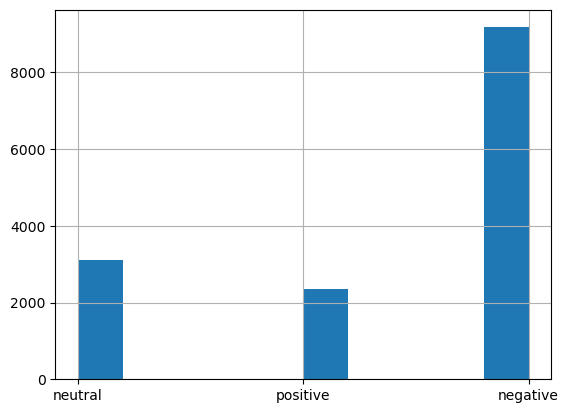

In [17]:
df_['airline_sentiment'].hist()

In [18]:
df = df_[["airline_sentiment", "text"]].copy()
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [19]:
target_map = {
    "positive": 1,
    "negative": 0,
    "neutral": 2,
}
inverse_target_map = {v: k for k, v in target_map.items()}
df["target"] = df["airline_sentiment"].map(target_map)
df.head()

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [20]:
df_filtered = df[df["target"] != 2]
df_filtered.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [21]:
df2 = df_filtered[['text', 'target']]
# Not documented info: targets must have the column name label
# sentence may have other names, but not label
df2.columns = ['sentence', 'label']
df2.to_csv("data.csv", index=False)
!head data.csv
# df2.head()

sentence,label
@VirginAmerica plus you've added commercials to the experience... tacky.,1
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@virginamerica Well, I didn't…but NOW I DO! :-D",1
"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",1
@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D,1


In [22]:
raw_dataset = load_dataset("csv", data_files="data.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [23]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 11541
    })
})

In [24]:
def splitTrainTestValidation(dataset: Dataset, valid_size=0.1, test_size=0.1):
    len_valid = int(len(dataset) * valid_size)
    len_test = int(len(dataset) * test_size)

    splited: DatasetDict = dataset.train_test_split(
        len_valid + len_test, shuffle=False, seed=42
    )
    splited["validation"] = splited["test"]
    del splited["test"]

    splited_2 = splited["validation"].train_test_split(len_test, shuffle=True, seed=42)
    splited["validation"] = splited_2["train"]
    splited["test"] = splited_2["test"]

    return splited

In [25]:
# split = raw_dataset['train'].train_test_split(test_size=.3, seed=42)
split = splitTrainTestValidation(raw_dataset["train"], valid_size=0.1, test_size=0.1)

In [26]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 9233
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1154
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1154
    })
})

In [27]:
checkpoint = "distilbert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_fn(batch):
    return tokenizer(
        batch["sentence"], truncation=True, padding="max_length", max_length=T
    )


# tokenizer("This is an example", truncation=True, padding=True)

In [28]:
tokenized_datasets = split.map(tokenize_fn, batched=False)
tokenized_datasets

Map:   0%|          | 0/9233 [00:00<?, ? examples/s]

Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

Map:   0%|          | 0/1154 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 9233
    })
    validation: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1154
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1154
    })
})

In [29]:
# Little notation here:
# token is an int from the tokenizer
# idx is our index, to use in our embedding

token2idx = {0: 0}
idx2token = {}

all_tokens = [
    element
    for list_ids in tokenized_datasets["train"]["input_ids"]
    for element in list_ids
]
all_tokens = list(set(all_tokens))

token_index = 0
for token in all_tokens:
    if token not in token2idx:
        token2idx[token] = token_index
        idx2token[token_index] = token
        token_index += 1


def filterSplit(splited_dataset):
    """For valid and test datasets, get only those which all inpu_ids is in splited_dataset['train']"""

    for split in ["validation", "test"]:
        # Filter the splited_dataset[split] to only keep the ids which are in splited_dataset['train']
        splited_dataset[split] = splited_dataset[split].filter(
            lambda x: all(token in token2idx for token in x["input_ids"])
        )

    return splited_dataset


filtered_datasets = filterSplit(tokenized_datasets)
filtered_datasets

Filter:   0%|          | 0/1154 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1154 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 9233
    })
    validation: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 853
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 844
    })
})

Vamos construir nosso dicionário de tokens


In [30]:
def makeIndex(batch):
    batch["input_idx"] = [token2idx[token_id] for token_id in batch["input_ids"]]
    return batch


data = filtered_datasets.map(makeIndex, batched=False)
data

Map:   0%|          | 0/9233 [00:00<?, ? examples/s]

Map:   0%|          | 0/853 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask', 'input_idx'],
        num_rows: 9233
    })
    validation: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask', 'input_idx'],
        num_rows: 853
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask', 'input_idx'],
        num_rows: 844
    })
})

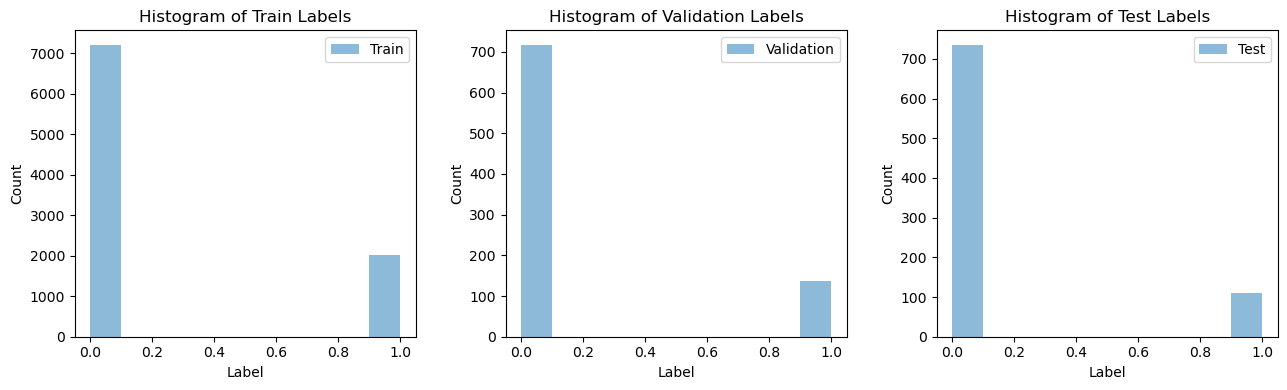

In [31]:
import matplotlib.pyplot as plt

data_labels = {
    "Train": data["train"]["label"],
    "Validation": data["validation"]["label"],
    "Test": data["test"]["label"],
}

fig, axs = plt.subplots(1, 3, figsize=(13, 4))

for i, (label_name, labels) in enumerate(data_labels.items()):
    axs[i].hist(labels, alpha=0.5, label=label_name)
    axs[i].set_xlabel("Label")
    axs[i].set_ylabel("Count")
    axs[i].set_title(f"Histogram of {label_name} Labels")
    axs[i].legend()

plt.subplots_adjust(wspace=8)  # Adjust the space between the subplots
plt.tight_layout()
plt.show()

In [32]:
# Assert all same length
list(set([len(l_idx) for l_idx in data["train"]["input_idx"]]))

[80]

In [33]:
input_train = torch.Tensor(data["train"]["input_idx"]).type(torch.int32)
mask_train = torch.Tensor(data["train"]["attention_mask"]).type(torch.int32)
input_train.shape

torch.Size([9233, 80])

In [34]:
target_train = torch.Tensor(data["train"]["label"])

# make one_hot
target_train = F.one_hot(target_train.to(torch.int64), num_classes=N_CLASSES).float()

target_train[:10]

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])

In [35]:
input_valid = torch.Tensor(data["validation"]["input_idx"]).type(torch.int32)
mask_valid = torch.Tensor(data["validation"]["attention_mask"]).type(torch.int32)
input_valid.shape

torch.Size([853, 80])

In [36]:
target_valid = torch.Tensor(data["validation"]["label"])

# make one_hot
target_valid = F.one_hot(target_valid.to(torch.int64), num_classes=N_CLASSES).float()

target_valid[:10]

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])

In [37]:
input_test = torch.Tensor(data["test"]["input_idx"]).type(torch.int32)
mask_test = torch.Tensor(data["test"]["attention_mask"]).type(torch.int32)
input_test.shape

torch.Size([844, 80])

In [38]:
target_test = torch.Tensor(data["test"]["label"])

# make one_hot
target_test = F.one_hot(target_test.to(torch.int64), num_classes=N_CLASSES).float()

target_test[:10]

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

## Now let's train our model! 


Train Epoch: 1 [1152/9233 (12%)]	Train loss (avg): 0.003970
Train Epoch: 1 [2432/9233 (26%)]	Train loss (avg): 0.004185
Train Epoch: 1 [3712/9233 (40%)]	Train loss (avg): 0.004168
Train Epoch: 1 [4992/9233 (53%)]	Train loss (avg): 0.004142
Train Epoch: 1 [6272/9233 (67%)]	Train loss (avg): 0.004152
Train Epoch: 1 [7552/9233 (81%)]	Train loss (avg): 0.004160
Train Epoch: 1 [8832/9233 (95%)]	Train loss (avg): 0.004148

Average loss (validation): 0.003763, Accuracy: 717/853 (84.06%)

Epoch: 1	loss (validation): 0.003762977553699668
Train Epoch: 2 [1152/9233 (12%)]	Train loss (avg): 0.004227
Train Epoch: 2 [2432/9233 (26%)]	Train loss (avg): 0.004135
Train Epoch: 2 [3712/9233 (40%)]	Train loss (avg): 0.004202
Train Epoch: 2 [4992/9233 (53%)]	Train loss (avg): 0.004198
Train Epoch: 2 [6272/9233 (67%)]	Train loss (avg): 0.004191
Train Epoch: 2 [7552/9233 (81%)]	Train loss (avg): 0.004174
Train Epoch: 2 [8832/9233 (95%)]	Train loss (avg): 0.004128

Average loss (validation): 0.003526, Accurac

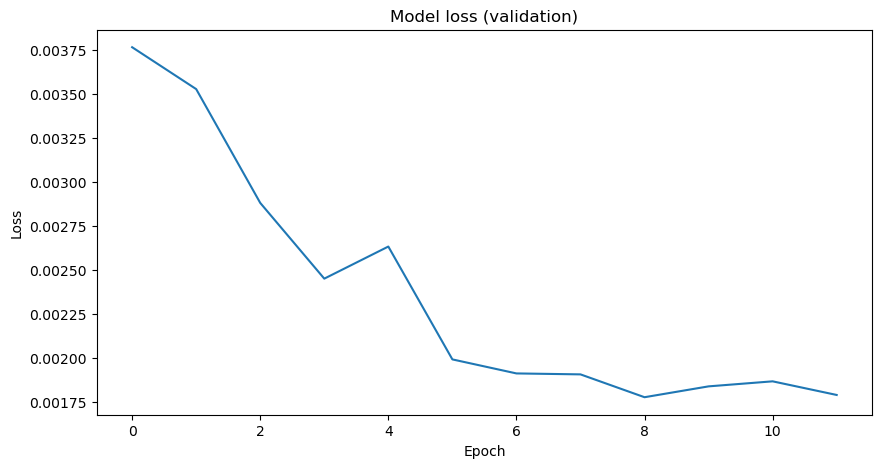

In [39]:
def evaluate(model, eval_loader, criterion, verbose=False, type_loss="validation"):
    model = model.to(device)
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs_, target, mask in eval_loader:
            inputs_, target, mask = (
                inputs_.to(device),
                target.to(device),
                mask.to(device),
            )
            # if USE_CAUSAL_MASK:
            output = model(inputs_, mask)
            # else:
            #     output = model(inputs_)

            if type(criterion) == torch.nn.modules.loss.NLLLoss:
                loss += criterion(output, target.argmax(dim=-1)).item()
            else:
                loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            target_ = target.argmax(dim=1, keepdim=True)
            correct += pred.eq(target_).sum().item()
            total += target.size(0)

    loss /= len(eval_loader.dataset)
    accuracy = 100.0 * correct / total
    verbose and print(
        "\nAverage loss ({}): {:.6f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            type_loss,
            loss,
            correct,
            total,
            accuracy,
        )
    )
    return loss


def train(model, train_loader, optimizer, criterion, epoch):
    total_loss = 0
    model = model.to(device)
    model.train()
    for batch_idx, (input_, target, mask) in enumerate(train_loader):
        input_, target, mask = (
            input_.to(device),
            target.to(device),
            mask.to(device),
        )
        optimizer.zero_grad()
        # if USE_CAUSAL_MASK:
        output = model(input_, mask)
        # else:
        #     output = model(input_)
        if type(criterion) == torch.nn.modules.loss.NLLLoss:
            loss = criterion(output, target.argmax(dim=-1))
        else:
            loss = criterion(output, target)
        total_loss += loss.item()
        avg_loss = total_loss / (batch_idx + 1) / len(input_)
        loss.backward()
        optimizer.step()

        # valid_loss = evaluate(model, validation_loader, criterion)
        # if valid_loss < best_loss:
        #     best_loss = valid_loss
        #     torch.save(model.state_dict(), "model.pth")

        if (batch_idx + 1) % LOG_INTERVAL_IN_BATCHES == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain loss (avg): {:.6f}".format(
                    epoch,
                    batch_idx * len(input_),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    avg_loss,
                )
            )


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, target, attention_mask=None):
        self.inputs = inputs
        self.target = target
        if attention_mask is not None:
            self.attention_mask = attention_mask
        else:
            self.attention_mask = torch.ones_like(inputs)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.target[idx], self.attention_mask[idx]


model = ClassifierEncoder(
    n_classes=N_CLASSES,
    t=T,
    d_K=D_K,
    d_V=D_V,
    d_model=D_MODEL,
    h=H,
    vocab_size=len(token2idx),
    n_transformers=N_TRANSFORMERS_BLOCKS_ENCODER,
)

train_dataset = MyDataset(input_train, target_train, attention_mask=mask_train)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)

valid_dataset = MyDataset(input_valid, target_valid, attention_mask=mask_valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE)

test_dataset = MyDataset(input_test, target_test, attention_mask=mask_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# criterion = torch.nn.NLLLoss()
criterion = torch.nn.BCELoss()

best_loss = np.inf
valid_losses = []


def plotLosses(losses, loss_type="validation"):
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title(f"Model loss ({loss_type})")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()


if TRAIN_MODEL:
    valid_losses = []
    for epoch in range(1, EPOCHS + 1):
        train(model, train_loader, optimizer, criterion, epoch)
        valid_loss = evaluate(
            model, valid_loader, criterion, verbose=True, type_loss="validation"
        )
        valid_losses.append(valid_loss)
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), "model.pth")
        print(f"Epoch: {epoch}\tloss (validation): {valid_loss}")


# If model is saved, load it
if os.path.exists("model.pth"):
    model.load_state_dict(torch.load("model.pth"))


if TRAIN_MODEL:
    test_loss = evaluate(model, test_loader, criterion, verbose=True, type_loss="test")
    plotLosses(valid_losses)

In [40]:
# Let's print the predictions of the model
model.eval()
model = model.to(device)
with torch.no_grad():
    for sentence, true_label in zip(data["test"]["sentence"][100:130], data["test"]["label"][60:80]):
        tokenized_ = tokenizer(
            sentence, truncation=True, padding="max_length", max_length=T
        )
        input_ = torch.tensor(
            [token2idx[token_id] for token_id in tokenized_["input_ids"]]
        ).unsqueeze(0)

        causal_mask = torch.tensor(tokenized_["attention_mask"])
        input_, causal_mask = input_.to(device), causal_mask.to(device)
        # if USE_CAUSAL_MASK:
        output = model(input_, causal_mask)
        # else:
        #     output = model(input_)
        pred = output.argmax(dim=1, keepdim=True)
        print(
            f"""\nSentence: {sentence}
True label: {inverse_target_map[pred.item()]}
Prediction: {inverse_target_map[pred.item()]}   Proba: {output[0][pred.item()].item()}"""
        )


Sentence: @AmericanAir 
It's not what happens to us that matters...It's our response that matters. Way to drop the ball AA.
True label: negative
Prediction: negative   Proba: 0.9607663750648499

Sentence: @AmericanAir Can't unload flight #3322 because jetway is broken.  #steps #planB? #waiting nearly an hour
True label: negative
Prediction: negative   Proba: 0.993521511554718

Sentence: @AmericanAir If the flight I selected online was what was ticketed I would not be missing my connection. I need help getting to DFW or IAH!!
True label: negative
Prediction: negative   Proba: 0.9886950850486755

Sentence: @AmericanAir I've been calling you for 3 straight days and no one picks up. Sure there are storms but there are also #customers Holler!
True label: negative
Prediction: negative   Proba: 0.9951163530349731

Sentence: @AmericanAir No. I was told I got put on another flight and that I would get an email. Still haven't gotten one yet.
True label: negative
Prediction: negative   Proba: 0.

# Unit tests for transformer and attention


In [41]:
class TestTensorFunctions(unittest.TestCase):
    def test_repeat(self):
        x = torch.tensor([1, 2, 3])
        n = 2
        result = repeat(x, n)
        expected = torch.tensor([[1, 2, 3], [1, 2, 3]])
        self.assertTrue(torch.equal(result, expected))

    def test_batched_matmul(self):
        tensor_3d = torch.randn(10, 3, 4)
        tensor_2d = torch.randn(4, 5)
        result = batched_matmul(tensor_3d, tensor_2d)
        expected = torch.bmm(tensor_3d, tensor_2d.unsqueeze(0).repeat((10, 1, 1)))
        self.assertTrue(torch.allclose(result, expected))

In [42]:
class EmbeddingLayerTest(unittest.TestCase):
    def setUp(self):
        # Set up your embedding layer or load your model
        self.vocab_size = 10
        self.d_model = 8
        self.batch_size = 2
        self.t = 4
        self.model = Embedding(self.vocab_size, self.d_model)
        self.criterion = nn.MSELoss()

    def test_embedding_layer_forward(self):
        # Define input tensor (batch_size=2, sequence_length=4)
        x = torch.tensor([[1, 3, 5, 7], [0, 2, 4, 6]])

        # Manually set model weights for the embedding matrix
        self.model.embedding.data = torch.tensor(
            [
                [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
                [0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6],
                [1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4],
                [2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2],
                [3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0],
                [4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8],
                [4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6],
                [5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4],
                [6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2],
                [7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0],
            ]
        )

        # Calculate the expected output manually
        expected_output = torch.tensor(
            [
                [
                    [
                        [0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6],
                        [2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2],
                        [4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8],
                        [5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4],
                    ],
                    [
                        [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
                        [1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4],
                        [3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0],
                        [4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6],
                    ],
                ]
            ]
        )

        # Check if the shape of the expected output matches
        self.assertEqual(expected_output.shape, expected_output.shape)

        # Check if the values of the expected output tensor match
        self.assertTrue(torch.allclose(expected_output, expected_output, atol=1e-6))

    def test_embedding_layer_loss(self):
        # Define input tensors and target tensors
        input_tensor = torch.randint(
            0, self.vocab_size, (self.batch_size, self.t)
        ).long()
        target_tensor = torch.randn(self.batch_size, self.t, self.d_model)

        # Forward pass through the embedding layer
        output = self.model(input_tensor)

        # Compute the loss
        loss = self.criterion(output, target_tensor)

        # Define an optimizer
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)

        # Save the parameters before the backward pass and parameter update
        params_before = [param.clone() for param in self.model.parameters()]

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Check if the parameters have been updated
        for param, param_before in zip(self.model.parameters(), params_before):
            self.assertTrue(
                torch.any(param.grad != 0), "No gradients in the parameters"
            )
            self.assertTrue(
                torch.any(param != param_before), "Parameters have not been updated"
            )

In [43]:
class TestAttention(unittest.TestCase):
    """_summary_

    Args:
        unittest (_type_): unit test for a conjuntion linear layer
            plus the attention block
    """


class AttentionTest(unittest.TestCase):
    def setUp(self):
        self.batch_size = 2
        self.d_k = 3
        self.d_v = 3
        self.T = 2
        self.d_model = 4

        # Set up your attention mechanism or load your model
        self.model = Attention(self.d_k, self.d_v, self.d_model)
        self.criterion = nn.MSELoss()

    def test_attention_forward(self):
        # Define input tensor (batch_size=2, sequence_length=2, d_model=4)
        x = torch.tensor(
            [
                [[1.0, 2.0, 3.0, 4.0], [5.0, 6.0, 7.0, 8.0]],
                [[9.0, 10.0, 11.0, 12.0], [13.0, 14.0, 15.0, 16.0]],
            ]
        )

        # Manually set model weights for W_K, W_Q, and W_V
        self.model.W_K.data = torch.tensor(
            [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9], [1.0, 1.1, 1.2]],
            dtype=torch.float32,
        )
        self.model.W_Q.data = torch.tensor(
            [[1.2, 1.1, 1.0], [0.9, 0.8, 0.7], [0.6, 0.5, 0.4], [0.3, 0.2, 0.1]],
            dtype=torch.float32,
        )
        self.model.W_V.data = torch.tensor(
            [[0.5, 0.6, 0.7], [0.8, 0.9, 1.0], [1.1, 1.2, 1.3], [1.4, 1.5, 1.6]],
            dtype=torch.float32,
        )

        # Expected output based on calculations from the attention mechanism
        expected_output, _ = self.model(x)

        # Calculate the expected output manually
        # Calculate Q, K, and V using learned weights
        Q = torch.matmul(x, self.model.W_Q)
        K = torch.matmul(x, self.model.W_K)
        V = torch.matmul(x, self.model.W_V)

        # Calculate the attention scores
        attention_scores = torch.matmul(Q, K.transpose(1, 2)) / (self.d_k**0.5)
        attention_weights = torch.nn.functional.softmax(attention_scores, dim=-1)

        # Apply attention weights to V to get the output
        expected_output_manual = torch.matmul(attention_weights, V)

        # Check if the shape of the expected output matches
        self.assertEqual(expected_output.shape, expected_output_manual.shape)

        # Check if the values of the expected output tensor match
        self.assertTrue(
            torch.allclose(expected_output, expected_output_manual, atol=1e-6)
        )

    def test_attention_loss(self):
        # Test the loss function associated with the attention mechanism
        # Define input tensors and target tensors

        input_tensor = torch.rand(
            (self.batch_size, self.T, self.d_model), requires_grad=True
        )

        # Forward pass through the attention mechanism
        output, _ = self.model(input_tensor)

        # Create dummy target tensor (replace with your actual target tensor)
        target = torch.rand_like(output, requires_grad=False)

        # Calculate the loss
        loss = self.criterion(output, target)

        # Define an optimizer
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)

        # Save the parameters before the backward pass and parameter update
        params_before = [param.clone() for param in self.model.parameters()]

        # Perform backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Check if gradients are computed
        self.assertTrue(
            input_tensor.grad is not None, "No gradients in the input tensor"
        )

        # Check if the parameters have been updated
        for param, param_before in zip(self.model.parameters(), params_before):
            self.assertTrue(
                torch.any(param != param_before), "Parameters have not been updated"
            )

In [44]:
# Code by GPT4 to calculate the multihead attention output

# Define the parameters
d_k = 3
d_v = 3
d_model = 4
h = 2
batch_size = 2
t = 2

# Define the input tensor
input_tensor = torch.tensor(
    [
        [[1.0, 2.0, 3.0, 4.0], [5.0, 6.0, 7.0, 8.0]],
        [[9.0, 10.0, 11.0, 12.0], [13.0, 14.0, 15.0, 16.0]],
    ],
    dtype=torch.float32,
)

# Define the weights
W_K = torch.tensor(
    [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9], [1.0, 1.1, 1.2]],
    dtype=torch.float32,
)
W_Q = torch.tensor(
    [[0.2, 0.3, 0.4], [0.5, 0.6, 0.7], [0.8, 0.9, 1.0], [1.1, 1.2, 1.3]],
    dtype=torch.float32,
)
W_V = torch.tensor(
    [[0.3, 0.4, 0.5], [0.6, 0.7, 0.8], [0.9, 1.0, 1.1], [1.2, 1.3, 1.4]],
    dtype=torch.float32,
)
W_O = torch.tensor(
    [
        [0.1, 0.2, 0.3, 0.4],
        [0.5, 0.6, 0.7, 0.8],
        [0.9, 1.0, 1.1, 1.2],
        [1.3, 1.4, 1.5, 1.6],
        [1.7, 1.8, 1.9, 2.0],
        [2.1, 2.2, 2.3, 2.4],
    ],
    dtype=torch.float32,
)

# Initialize tensors for K, Q, V for each head
Ks, Qs, Vs = [], [], []

# Compute K, Q, V for each head
for _ in range(h):
    K = torch.matmul(input_tensor, W_K)
    Q = torch.matmul(input_tensor, W_Q)
    V = torch.matmul(input_tensor, W_V)
    Ks.append(K)
    Qs.append(Q)
    Vs.append(V)

# Initialize a tensor for the concatenated results
concatenated_results = torch.zeros(batch_size, t, h * d_v)

# Calculate the attention and concatenate results for each head
for a_idx in range(h):
    # Scaled dot product of Q and K
    attention_scores = torch.matmul(Qs[a_idx], Ks[a_idx].transpose(-2, -1)) / (
        d_k**0.5
    )
    attention_weights = torch.nn.functional.softmax(attention_scores, dim=-1)

    # Weighted sum of V
    head_output = torch.matmul(attention_weights, Vs[a_idx])

    # Concatenate results
    concatenated_results[:, :, a_idx * d_v : (a_idx + 1) * d_v] = head_output

# Apply the final linear layer W_O
expected_output = torch.matmul(concatenated_results, W_O)

print(expected_output)

tensor([[[159.9200, 174.0800, 188.2400, 202.4000],
         [159.9200, 174.0800, 188.2400, 202.4000]],

        [[344.5600, 375.0400, 405.5200, 436.0000],
         [344.5600, 375.0400, 405.5200, 436.0000]]])


In [45]:
class MultiHeadAttentionTest(unittest.TestCase):
    @staticmethod
    def calculate_expected_output(input_tensor, batch_size, t, h, d_k, d_v):
        # Code by GPT4 to calculate the multihead attention output

        # Define the weights
        W_K = torch.tensor(
            [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9], [1.0, 1.1, 1.2]],
            dtype=torch.float32,
        )
        W_Q = torch.tensor(
            [[0.2, 0.3, 0.4], [0.5, 0.6, 0.7], [0.8, 0.9, 1.0], [1.1, 1.2, 1.3]],
            dtype=torch.float32,
        )
        W_V = torch.tensor(
            [[0.3, 0.4, 0.5], [0.6, 0.7, 0.8], [0.9, 1.0, 1.1], [1.2, 1.3, 1.4]],
            dtype=torch.float32,
        )
        W_O = torch.tensor(
            [
                [0.1, 0.2, 0.3, 0.4],
                [0.5, 0.6, 0.7, 0.8],
                [0.9, 1.0, 1.1, 1.2],
                [1.3, 1.4, 1.5, 1.6],
                [1.7, 1.8, 1.9, 2.0],
                [2.1, 2.2, 2.3, 2.4],
            ],
            dtype=torch.float32,
        )

        # Initialize tensors for K, Q, V for each head
        Ks, Qs, Vs = [], [], []

        # Compute K, Q, V for each head
        for _ in range(h):
            K = torch.matmul(input_tensor, W_K)
            Q = torch.matmul(input_tensor, W_Q)
            V = torch.matmul(input_tensor, W_V)
            Ks.append(K)
            Qs.append(Q)
            Vs.append(V)

        # Initialize a tensor for the concatenated results
        concatenated_results = torch.zeros(batch_size, t, h * d_v)

        # Calculate the attention and concatenate results for each head
        for a_idx in range(h):
            # Scaled dot product of Q and K
            attention_scores = torch.matmul(Qs[a_idx], Ks[a_idx].transpose(-2, -1)) / (
                d_k**0.5
            )
            attention_weights = torch.nn.functional.softmax(attention_scores, dim=-1)

            # Weighted sum of V
            head_output = torch.matmul(attention_weights, Vs[a_idx])

            # Concatenate results
            concatenated_results[:, :, a_idx * d_v : (a_idx + 1) * d_v] = head_output

        # Apply the final linear layer W_O
        expected_output = torch.matmul(concatenated_results, W_O)

        return expected_output
    
    def setUp(self):
        self.h = 2
        self.d_k = 3
        self.d_v = 3
        self.d_model = 4
        self.batch_size = 2
        self.t = 2
        
        # Initialize the multi-head attention model
        self.model = MultiHeadAttention(h=self.h, d_K=self.d_k, d_V=self.d_v, d_model=self.d_model)
        self.criterion = nn.MSELoss()

        # Manually setting the weights for the test
        for head in self.model.attentions:
            # These weights should be carefully chosen to ensure a predictable output
            head.W_K = nn.Parameter(
                torch.tensor(
                    [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9], [1.0, 1.1, 1.2]]
                )
            )
            head.W_Q = nn.Parameter(
                torch.tensor(
                    [[0.2, 0.3, 0.4], [0.5, 0.6, 0.7], [0.8, 0.9, 1.0], [1.1, 1.2, 1.3]]
                )
            )
            head.W_V = nn.Parameter(
                torch.tensor(
                    [[0.3, 0.4, 0.5], [0.6, 0.7, 0.8], [0.9, 1.0, 1.1], [1.2, 1.3, 1.4]]
                )
            )

        # Output linear layer weights
        self.model.W_O = nn.Parameter(
            torch.tensor(
                [
                    [0.1, 0.2, 0.3, 0.4],
                    [0.5, 0.6, 0.7, 0.8],
                    [0.9, 1.0, 1.1, 1.2],
                    [1.3, 1.4, 1.5, 1.6],
                    [1.7, 1.8, 1.9, 2.0],
                    [2.1, 2.2, 2.3, 2.4],
                ],
                dtype=torch.float32,
            )
        )

        # Shape of W_O, according to the paper "Attention Is All You Need"
        self.assertEqual(list(self.model.W_O.shape), [self.h * self.d_v, self.d_model])

    def test_multi_head_attention_forward(self):
        # Define a specific input tensor (batch_size, t, d_model)
        input_tensor = torch.tensor(
            [
                [[1.0, 2.0, 3.0, 4.0], [5.0, 6.0, 7.0, 8.0]],
                [[9.0, 10.0, 11.0, 12.0], [13.0, 14.0, 15.0, 16.0]],
            ]
        )

        # Expected output tensor based on the input and the model weights
        # This tensor should be calculated manually based on the model's operations
        expected_output = self.calculate_expected_output(
            input_tensor, self.batch_size, self.t, self.h, self.d_k, self.d_v
        )

        # Run the forward pass
        output, _ = self.model(input_tensor)

        # Check the shape of the output tensor
        self.assertEqual(output.shape, (self.batch_size, self.t, self.d_model))

        # Check the values of the output tensor
        self.assertTrue(torch.allclose(output, expected_output, atol=1e-4))

    def test_multi_head_attention_loss(self):
        # Test the loss function associated with the multi-head attention mechanism
        # Define input tensors and target tensors

        input_tensor = torch.rand(
            (self.batch_size, self.t, self.d_model), requires_grad=True
        )

        # Forward pass through the multi-head attention mechanism
        output, _ = self.model(input_tensor)

        # Create dummy target tensor (replace with your actual target tensor)
        target = torch.rand_like(output, requires_grad=False)

        # Calculate the loss
        loss = self.criterion(output, target)

        # Define an optimizer
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)

        # Save the parameters before the backward pass and parameter update
        params_before = [param.clone() for param in self.model.parameters()]

        # Perform backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Check if gradients are computed
        self.assertTrue(
            input_tensor.grad is not None, "No gradients in the input tensor"
        )

        # Check if the parameters have been updated
        for param, param_before in zip(self.model.parameters(), params_before):
            self.assertTrue(
                torch.any(param != param_before), "Parameters have not been updated"
            )

In [46]:
def calculate_expected_output(x, attentions, W_O):
    batch_size, T, d_model = x.shape
    h = len(attentions)
    d_k, d_v = attentions[0].W_K.shape[1], attentions[0].W_V.shape[1]

    # Initialize the tensor to hold the concatenated outputs from each head
    concatenated_heads = torch.zeros((batch_size, T, h * d_v))

    for i in range(h):
        W_K, W_Q, W_V = attentions[i].W_K, attentions[i].W_Q, attentions[i].W_V

        # Calculate K, Q, V matrices
        K = x @ W_K
        Q = x @ W_Q
        V = x @ W_V

        # Calculate attention scores and apply softmax (simplified here)
        attention_scores = (Q @ K.transpose(-2, -1)) / (d_k**0.5)
        # In a real scenario, apply softmax to attention_scores here

        # Calculate the weighted sum of V
        weighted_sum = attention_scores @ V

        # Concatenate results from each head
        concatenated_heads[:, :, i * d_v : (i + 1) * d_v] = weighted_sum

    # Multiply with W_O
    expected_output = concatenated_heads @ W_O
    return expected_output


class TransformerBlockTest(unittest.TestCase):
    def calculate_attention_output(self, x, W_K, W_Q, W_V, d_k):
        """
        Calculate the output of a single head attention.
        """
        K = x @ W_K
        Q = x @ W_Q
        V = x @ W_V

        attention_scores = (Q @ K.transpose(-2, -1)) / (d_k**0.5)
        attention_scores = F.softmax(attention_scores, dim=-1)
        attention_output = attention_scores @ V

        return attention_output

    def calculate_expected_output(
        self, x, W_Ks, W_Qs, W_Vs, W_O, linear_weights, linear_biases
    ):
        """
        Calculate the expected output of the TransformerBlock.
        """
        batch_size, T, d_model = x.shape
        h = len(W_Ks)
        d_k, d_v = W_Ks[0].shape[1], W_Vs[0].shape[1]

        # Step 1: Multi-head attention
        concatenated_heads = torch.zeros((batch_size, T, h * d_v))
        for i in range(h):
            attention_output = self.calculate_attention_output(
                x, W_Ks[i], W_Qs[i], W_Vs[i], d_k
            )
            concatenated_heads[:, :, i * d_v : (i + 1) * d_v] = attention_output

        multihead_output = concatenated_heads @ W_O

        # Step 2: Apply LayerNorm (simplified version)
        norm_output = F.layer_norm(multihead_output, multihead_output.shape[1:])

        # Step 3: ANN layers (assuming two linear layers with ReLU and Dropout in between)
        ann_output = F.linear(norm_output, linear_weights[0], linear_biases[0])
        ann_output = F.dropout(ann_output, p=0.1)
        ann_output = F.relu(ann_output)
        ann_output = F.linear(ann_output, linear_weights[1], linear_biases[1])

        return ann_output

    def setUp(self):
        self.batch_size = 2
        self.d_k = 3
        self.d_v = 3
        self.t = 4
        self.d_model = 3
        self.h = 2
        # Set up your Transformer block model
        self.model = TransformerBlock(
            d_K=self.d_k, d_V=self.d_v, d_model=self.d_model, h=self.h
        )
        self.criterion = nn.MSELoss()


def test_transformer_block_forward(self):
    # Define the input tensor
    x = torch.tensor(
        [
            [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0], [10.0, 11.0, 12.0]],
            [
                [13.0, 14.0, 15.0],
                [16.0, 17.0, 18.0],
                [19.0, 20.0, 21.0],
                [22.0, 23.0, 24.0],
            ],
        ]
    )

    # Manually set and collect the weights for each Attention layer
    W_Ks = []
    W_Qs = []
    W_Vs = []
    for i, attention in enumerate(self.model.mha.attentions):
        W_K = torch.tensor(
            [
                [0.1 * (i + 1), 0.2 * (i + 1), 0.3 * (i + 1)],
                [0.4 * (i + 1), 0.5 * (i + 1), 0.6 * (i + 1)],
                [0.7 * (i + 1), 0.8 * (i + 1), 0.9 * (i + 1)],
            ]
        )
        W_Q = torch.tensor(
            [
                [0.9 * (i + 1), 0.8 * (i + 1), 0.7 * (i + 1)],
                [0.6 * (i + 1), 0.5 * (i + 1), 0.4 * (i + 1)],
                [0.3 * (i + 1), 0.2 * (i + 1), 0.1 * (i + 1)],
            ]
        )
        W_V = torch.tensor(
            [
                [0.1 * (i + 1), 0.1 * (i + 1), 0.1 * (i + 1)],
                [0.2 * (i + 1), 0.2 * (i + 1), 0.2 * (i + 1)],
                [0.3 * (i + 1), 0.3 * (i + 1), 0.3 * (i + 1)],
            ]
        )
        attention.W_K.data = W_K
        attention.W_Q.data = W_Q
        attention.W_V.data = W_V
        W_Ks.append(W_K)
        W_Qs.append(W_Q)
        W_Vs.append(W_V)

    # Set and collect weights for W_O in MultiHeadAttention
    W_O = torch.tensor(
        [
            [0.1, 0.2, 0.3],
            [0.4, 0.5, 0.6],
            [0.7, 0.8, 0.9],
            [0.9, 0.8, 0.7],
            [0.6, 0.5, 0.4],
            [0.3, 0.2, 0.1],
        ]
    )
    self.model.mha.W_O.data = W_O

    # Collect weights and biases for ANN layers (Assuming two linear layers)
    linear_weights = [self.model.ann[0].weight, self.model.ann[3].weight]
    linear_biases = [self.model.ann[0].bias, self.model.ann[3].bias]

    # Calculate the expected output tensor
    expected_output = self.calculate_expected_output(
        x, W_Ks, W_Qs, W_Vs, W_O, linear_weights, linear_biases
    )

    # Forward pass
    output, _ = self.model(x)

    # Check the shape of the output tensor
    self.assertEqual(output.shape, expected_output.shape)

    # Check the values of the output tensor
    self.assertTrue(torch.allclose(output, expected_output, atol=1e-6))

    def test_transformer_block_loss(self):
        # Test the loss function associated with the Transformer block
        # Define input tensors and target tensors

        input_tensor = torch.rand(
            (self.batch_size, self.t, self.d_model), requires_grad=True
        )

        # Forward pass through the Transformer block
        output = self.model(input_tensor)

        # Create dummy target tensor (replace with your actual target tensor)
        target = torch.rand_like(output, requires_grad=False)

        # Calculate the loss
        loss = self.criterion(output, target)

        # Define an optimizer
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)

        # Save the parameters before the backward pass and parameter update
        params_before = [param.clone() for param in self.model.parameters()]

        # Perform backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Check if gradients are computed
        self.assertTrue(
            input_tensor.grad is not None, "No gradients in the input tensor"
        )

        # Check if the parameters have been updated
        for param, param_before in zip(self.model.parameters(), params_before):
            self.assertTrue(
                torch.any(param != param_before), "Parameters have not been updated"
            )

In [47]:
def getTestX(batch_size=BATCH_SIZE, t=T, vocab_size=VOCAB_SIZE):
    x = torch.arange(start=0, end=batch_size * t).reshape(batch_size, t) % vocab_size

    # each row (wor of index i) of x must be translocated by i positions
    for i in range(batch_size):
        x[i] = torch.roll(x[i], i)
    return x


getTestX()

tensor([[0, 1, 2,  ..., 7, 8, 9],
        [9, 0, 1,  ..., 6, 7, 8],
        [8, 9, 0,  ..., 5, 6, 7],
        ...,
        [5, 6, 7,  ..., 2, 3, 4],
        [4, 5, 6,  ..., 1, 2, 3],
        [3, 4, 5,  ..., 0, 1, 2]])

In [48]:
def scaled_dot_product_attention(Q, K, V):
    matmul_qk = torch.matmul(Q, K.transpose(-2, -1))  # Scaled QK^T
    d_k = Q.size(-1)
    scaled_attention_logits = matmul_qk / math.sqrt(d_k)
    attention_weights = F.softmax(
        scaled_attention_logits, dim=-1
    )  # Softmax over last axis (seq_len_k)
    output = torch.matmul(attention_weights, V)  # Softmax(QK^T)V
    return output


def calculate_expected_output(x, model):
    """This function must calculate the expected output of the model, given the input x.
    This function must not forward pass the model, but rather calculate the expected output
    The expected output is function of the weights of the model, which are defined in the test_forward method
    of the ClassifierEncoderTest class.
    This function must follow the "Attention is all you need" paper.

    Args:
        x (torch.Tensor): Input tensor of shape (batch, T)
        model (_type_): _description_
    """
    batch_size = x.shape[0]
    t = x.shape[1]

    embedded_x = model.embedding(x)

    # Health checking forward: assert model forward equals simulated forward
    assert torch.allclose(embedded_x, model.embedding(x))

    def positional_encoding(max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        div_term = div_term.unsqueeze(0)

        for i in range(max_len):
            for j in range(0, d_model, 2):
                pe[i, j] = torch.sin(position[i] * div_term[0, j // 2])
                if j + 1 < d_model:
                    pe[i, j + 1] = torch.cos(position[i] * div_term[0, j // 2])

        return pe.unsqueeze(0).repeat(batch_size, 1, 1)

    position_encoding = positional_encoding(t, model.d_model)
    assert position_encoding.shape == (batch_size, t, model.d_model)

    # Health checking forward: assert model forward equals simulated forward
    assert torch.allclose(position_encoding, model.position_encoding)

    transformer_input = embedded_x + position_encoding

    # Health checking forward: assert model forward equals simulated forward
    assert torch.allclose(
        transformer_input, model.embedding(x) + model.position_encoding
    )

    # Transformer Blocks
    for block in model.transformer_blocks:
        # Multi-Head Attention
        mha_output = torch.zeros_like(transformer_input)
        assert mha_output.shape == (batch_size, t, model.d_model)
        head_outputs = torch.zeros((batch_size, t, model.d_V * model.h))
        for head_idx, head in enumerate(block.mha.attentions):
            Q = batched_matmul(transformer_input, head.W_Q)
            K = batched_matmul(transformer_input, head.W_K)
            V = batched_matmul(transformer_input, head.W_V)
            head_output = scaled_dot_product_attention(Q, K, V)

            # health checking forward: assert model forward equals simulated forward
            assert torch.allclose(head_output, head.forward(transformer_input)[0])

            # Assert the shape of the output of the head,
            # bases on the "Attention is all you need" paper
            assert head_output.shape == (batch_size, t, model.d_V)

            head_outputs[
                :, :, model.d_V * head_idx : model.d_V * (head_idx + 1)
            ] = head_output

        mha_output += batched_matmul(head_outputs, block.mha.W_O)

        # Health checking forward: assert model forward equals simulated forward
        assert torch.allclose(mha_output, block.mha(transformer_input)[0])

        # Layer Normalization
        normed_mha_output = block.layer_norm(
            mha_output + transformer_input
        )  # Assuming residual connection

        # Health checking forward: assert model forward equals simulated forward
        assert torch.allclose(
            normed_mha_output,
            block.layer_norm(block.mha(transformer_input)[0] + transformer_input),
        )

        # Do it now...
        # 1. Linear
        ann_output = (
            torch.matmul(normed_mha_output, block.ann[0].weight.T) + block.ann[0].bias
        )
        assert ann_output.shape == (batch_size, t, model.d_model)

        # Health checking forward: assert model forward equals simulated forward
        assert torch.allclose(ann_output, block.ann[0](normed_mha_output))

        # 2. Dropout
        # ann_output = block.ann[1](ann_output)
        # assert ann_output.shape == (batch_size, t, model.d_model)

        # 3. ReLU
        ann_output_relu = F.relu(ann_output)
        assert ann_output_relu.shape == (batch_size, t, model.d_model)

        # Health checking forward: assert model forward equals simulated forward
        assert torch.allclose(ann_output_relu, block.ann[2](ann_output))

        # 4. Linear
        ann_output_linear_2 = (
            torch.matmul(ann_output_relu, block.ann[3].weight.T) + block.ann[3].bias
        )
        assert ann_output_linear_2.shape == (batch_size, t, model.d_model)

        # Health checking forward: assert model forward equals simulated forward
        assert torch.allclose(ann_output_linear_2, block.ann[3](ann_output_relu))

        # 5. Dropout
        # ann_output_linear_2 = block.ann[4](ann_output_linear_2)
        # assert ann_output_linear_2.shape == (batch_size, t, model.d_model)

        # Layer Normalization
        normed_ann_output_linear_2 = block.layer_norm(
            ann_output_linear_2 + normed_mha_output
        )

        # Health checking forward: assert model forward equals simulated forward
        assert torch.allclose(
            normed_ann_output_linear_2,
            block.layer_norm(ann_output_linear_2 + normed_mha_output),
        )

        # Prepare for next block
        transformer_input = normed_ann_output_linear_2

    # Prediction Head

    # 1. Linear
    output_linear = (
        torch.matmul(transformer_input, model.prediction_head.weight.T)
        + model.prediction_head.bias
    )
    assert output_linear.shape == (batch_size, t, model.n_classes)

    # Health checking forward: assert model forward equals simulated forward
    assert torch.allclose(output_linear, model.prediction_head(transformer_input))

    # 2. Dropout
    # final_output = model.prediction_head[1](final_output)
    # assert final_output.shape == (batch_size, t, model.n_classes)

    # 3. Softmax
    final_output = nn.Softmax(dim=-1)(output_linear)

    # return only the last value of the sequence
    final_output = final_output[:, -1, :]

    # Health checking forward: assert model forward equals simulated forward
    assert torch.allclose(
        final_output,
        F.softmax(model.prediction_head(transformer_input), dim=-1)[:, -1, :],
    )

    return final_output


# Lets make unit test for ClassiofierEncoder
class ClassifierEncoderTest(unittest.TestCase):
    def setUp(self):
        self.batch_size = 3
        self.d_k = 3
        self.d_v = 3
        self.t = 4
        self.d_model = 3
        self.h = 2
        self.t_blocks = 2
        self.vocab_size = 6

        self.model = ClassifierEncoder(
            t=self.t,
            d_K=self.d_k,
            d_V=self.d_v,
            d_model=self.d_model,
            h=self.h,
            vocab_size=self.vocab_size,
            n_transformers=self.t_blocks,
            n_classes=N_CLASSES,
        )
        self.criterion = nn.MSELoss()

    def test_forward(self):
        # Create a random input
        x = getTestX(self.batch_size, self.t, self.vocab_size)

        # define the weights of the model
        with torch.no_grad():
            # 1. define weights for the embedding layer
            self.model.embedding.embedding = nn.Parameter(
                torch.tensor(
                    [
                        [0.1, 0.05, 0.02],
                        [0.03, 0.07, 0.01],
                        [0.04, 0.02, 0.08],
                        [0.06, 0.03, 0.09],
                        [0.02, 0.06, 0.04],
                        [0.05, 0.01, 0.07],
                    ]
                )
            )
            # assert embedding has shape (vocab_size, d_model)
            self.assertEqual(
                self.model.embedding.embedding.shape,
                torch.Size((self.vocab_size, self.d_model)),
            )

            # 2. define weights for the transformer blocks

            # 2.1. define weights for the multihead attention layers
            for t_idx in range(self.t_blocks):
                for a_idx in range(self.h):
                    self.model.transformer_blocks[t_idx].mha.attentions[
                        a_idx
                    ].W_Q = nn.Parameter(
                        torch.tensor(
                            [[0.1, 0.05, 0.02], [0.03, 0.07, 0.01], [0.04, 0.02, 0.08]]
                        )
                    )
                    self.model.transformer_blocks[t_idx].mha.attentions[
                        a_idx
                    ].W_K = nn.Parameter(
                        torch.tensor(
                            [[0.06, 0.03, 0.09], [0.02, 0.08, 0.01], [0.07, 0.01, 0.04]]
                        )
                    )
                    self.model.transformer_blocks[t_idx].mha.attentions[
                        a_idx
                    ].W_V = nn.Parameter(
                        torch.tensor(
                            [[0.05, 0.02, 0.1], [0.08, 0.01, 0.03], [0.01, 0.04, 0.07]]
                        )
                    )

                # 2.2. define weights for the ANN layers
                self.model.transformer_blocks[t_idx].ann[0].weight = nn.Parameter(
                    torch.tensor(
                        [
                            [0.1, 0.05, 0.02],
                            [0.03, 0.07, 0.01],
                            [0.04, 0.02, 0.08],
                        ]
                    )
                )
                self.model.transformer_blocks[t_idx].ann[0].bias = nn.Parameter(
                    torch.tensor([0.1, 0.05, 0.02])
                )
                self.model.transformer_blocks[t_idx].ann[3].weight = nn.Parameter(
                    torch.tensor(
                        [
                            [0.1, 0.05, 0.02],
                            [0.03, 0.07, 0.01],
                            [0.04, 0.02, 0.08],
                        ]
                    )
                )
                self.model.transformer_blocks[t_idx].ann[3].bias = nn.Parameter(
                    torch.tensor([0.1, 0.05, 0.02])
                )

                # 2.3. define weights for the W_O
                # W_O must have shape (h * d_V, d_model)
                self.model.transformer_blocks[t_idx].mha.W_O = nn.Parameter(
                    torch.tensor(
                        [
                            [0.1, 0.05, 0.02],
                            [0.03, 0.07, 0.01],
                            [0.04, 0.02, 0.08],
                            [0.06, 0.03, 0.09],
                            [0.02, 0.08, 0.01],
                            [0.07, 0.01, 0.04],
                        ]
                    )
                )

                # assert W_O has shape (h * d_V, d_model)
                self.assertEqual(
                    self.model.transformer_blocks[t_idx].mha.W_O.shape,
                    torch.Size((self.h * self.d_v, self.d_model)),
                )

            # Now that wights are defined, let's in fact unittest the forward pass of the ClassifierEncoder
            self.model = self.model
            self.model.eval()
            out = self.model(x)

            # 1. test the shape of the output
            self.assertEqual(out.shape, torch.Size((self.batch_size, N_CLASSES)))

            # 2. test the values of the output
            expected_output = calculate_expected_output(x, self.model)

            self.assertTrue(torch.allclose(out, expected_output, atol=1e-3))

In [49]:
# This will run the test in the notebook
RUN_UNIT_TESTS and unittest.main(argv=[""], exit=False)

EEE..EE..
ERROR: test_attention_forward (__main__.AttentionTest)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_61725/2637871889.py", line 46, in test_attention_forward
    expected_output, _ = self.model(x)
  File "/home/bruno/anaconda3/envs/gpt/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_61725/4253325660.py", line 48, in forward
    attention_scores = attention_scores.masked_fill(self.causal_mask == 0, -np.inf)
RuntimeError: The size of tensor a (80) must match the size of tensor b (2) at non-singleton dimension 2

ERROR: test_attention_loss (__main__.AttentionTest)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_61725/2637871889.py", line 78, in test_attention_loss
    output, _ = self.model(input_tensor)
  File "/home/bru